# Efficiently Process Large MD Trajectories with Chunking

Chunking is a technique for processing large datasets by dividing them into smaller, manageable subsets called chunks. When working with large MD trajectories represented as multiple PDB files (each as a frame), chunking optimizes memory usage and processing efficiency.

# Steps to Implement Chunking

Define Chunk Size:
Determine the number of PDB files (frames) to process in one chunk based on your system's memory and performance.

In [1]:
chunk_size = 100  # Number of PDB files per chunk


Iterate Over PDB Files in Chunks: 

1/ Load a subset of PDB files.

2/ Perform calculations (e.g., RMSD, Rg, etc.,).

3/ Save or accumulate results.

Aggregate Results:
After processing all chunks, combine results 

# Example script for RMSD calculation with MDTraj using Chunking

Processed frames 1 to 1
RMSD results saved to /home/samith/Documents/Exp/out/starPep_19319_experimental_prediction_coordinates_peptideOnly_rmsd.csv.
RMSD plot saved as /home/samith/Documents/Exp/out/starPep_19319_experimental_prediction_coordinates_peptideOnly_rmsd.png.


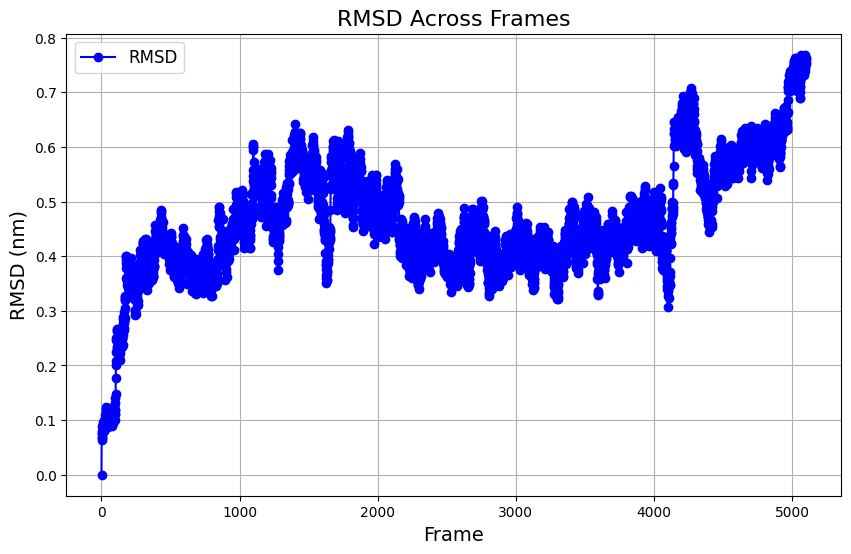

No PDB files found in out. Skipping...
RMSD calculation and plotting completed for all subfolders.


In [12]:
import os
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths for input and output directories
base_dir = '/home/samith/Documents/Exp'  # Base directory with subfolders
output_dir = '/home/samith/Documents/Exp/out'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

def extract_starpep_id(filename):
    """Extracts identifier from filenames with '_pbcFixed.pdb'."""
    return filename.split('_pbcFixed.pdb')[0] if '_pbcFixed.pdb' in filename else None

def calculate_rmsd_in_chunks(pdb_files, chunk_size=100, reference_frame=0):
    """Calculate RMSD in chunks for a list of PDB files."""
    rmsd_values = []
    reference_traj = md.load(pdb_files[reference_frame], top=pdb_files[0])  # Load reference frame

    for start in range(0, len(pdb_files), chunk_size):
        chunk = pdb_files[start:start + chunk_size]  # Get chunk of PDB files
        chunk_traj = md.load(chunk, top=pdb_files[0])  # Load chunk trajectory
        chunk_traj.superpose(reference_traj)  # Align to reference
        rmsd_chunk = md.rmsd(chunk_traj, reference_traj)  # Calculate RMSD
        rmsd_values.extend(rmsd_chunk)  # Accumulate results
        print(f"Processed frames {start + 1} to {start + len(chunk)}")

    return rmsd_values

def plot_rmsd(rmsd_values, output_png):
    """Plot RMSD values, save as PNG, and display the plot."""
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(rmsd_values) + 1), rmsd_values, marker='o', linestyle='-', color='b', label='RMSD')
    plt.title('RMSD Across Frames', fontsize=16)
    plt.xlabel('Frame', fontsize=14)
    plt.ylabel('RMSD (nm)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Save the plot as a PNG file
    plt.savefig(output_png, dpi=300)
    print(f"RMSD plot saved as {output_png}.")

    # Show the plot in Jupyter Notebook
    plt.show()

def process_subfolders(base_dir, output_dir, chunk_size=100):
    """Process all subfolders and calculate RMSD for PDB files."""
    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if not os.path.isdir(subfolder_path):  # Skip if not a directory
            continue

        # Gather all PDB files with '_pbcFixed.pdb' suffix
        pdb_files = sorted([
            os.path.join(subfolder_path, file)
            for file in os.listdir(subfolder_path)
            if file.endswith('_pbcFixed.pdb')
        ])

        if not pdb_files:
            print(f"No PDB files found in {subfolder}. Skipping...")
            continue

        starpep_id = extract_starpep_id(os.path.basename(pdb_files[0]))
        if not starpep_id:
            print(f"Invalid filename format in {subfolder}. Skipping...")
            continue

        # Define output file paths for CSV and PNG
        output_file_csv = os.path.join(output_dir, f"{starpep_id}_rmsd.csv")
        output_file_png = os.path.join(output_dir, f"{starpep_id}_rmsd.png")

        if os.path.exists(output_file_csv):
            print(f"Output file {output_file_csv} already exists. Skipping...")
            continue

        try:
            # Calculate RMSD in chunks
            rmsd = calculate_rmsd_in_chunks(pdb_files, chunk_size=chunk_size)

            # Save results to CSV
            pd.DataFrame({'Frame': np.arange(1, len(rmsd) + 1), 'RMSD': rmsd}).to_csv(output_file_csv, index=False)
            print(f"RMSD results saved to {output_file_csv}.")

            # Plot RMSD and save as PNG
            plot_rmsd(rmsd, output_file_png)

        except Exception as e:
            print(f"Error processing {subfolder}: {e}")

if __name__ == "__main__":
    process_subfolders(base_dir, output_dir, chunk_size=100)
    print("RMSD calculation and plotting completed for all subfolders.")


Inputs:

-  pdb_files: A list of file paths for PDB files in the subfolder.
-  chunk_size: Number of PDB files to process in each batch.
-  reference_frame: The frame used as a reference for RMSD calculations.


Process:

- Load a reference trajectory (reference_traj) for alignment.
- Process pdb_files in batches of size chunk_size.
- For each chunk:

    - Load the chunk using mdtraj.load.
    - Superpose frames in the chunk to the reference using chunk_traj.superpose.
    - Calculate RMSD for the chunk using mdtraj.
    - Append the chunk’s RMSD values to rmsd_values.